# Aprendizaje Supervisado

## Predicción de Destinos

En esta notebook aplicaremos tecnicas de aprendizaje para predecir el destino que un usuario de airbnb seleccionaría.

### Normalización de los datos

En esta notebook, el dataset está normalizado utilizando StandardScaler.


In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import itertools

from scipy.sparse import csr_matrix
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from yellowbrick.style import set_palette


from yellowbrick.classifier import ConfusionMatrix

import warnings

%load_ext autoreload
%autoreload 2

warnings.filterwarnings('ignore')


In [9]:
dataset_path = "..//datos//"
abnb_users_curated = "modified_train_users.csv"

In [14]:
users_df = pd.read_csv( dataset_path + abnb_users_curated)
users_df.head()


,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,...,first_browser,country_destination,has_booked,total_seconds,average_seconds,total_sessions,number_of_devices,gender_0,gender_1,gender_2
0,820tgsjxq7,1306281600,1243100889,-9223372037,1,38,1,0,5,7,...,7,0,False,0.0,0.0,1,1,0,1,0
1,4ft3gnwmtx,1285632000,1244589167,1280707200,0,56,0,3,5,2,...,14,1,True,0.0,0.0,1,1,1,0,0
2,bjjt8pjhuk,1323043200,1256968889,1347062400,0,42,1,0,5,2,...,13,2,True,0.0,0.0,1,1,1,0,0
3,87mebub9p4,1284422400,1260252665,1266451200,2,41,0,0,5,2,...,7,1,True,0.0,0.0,1,1,0,0,1
4,lsw9q7uk0j,1262390400,1262395558,1262649600,0,46,0,0,5,3,...,30,1,True,0.0,0.0,1,1,1,0,0


In [15]:
# Print the number of records and the total number of movies
print('The dataset contains: ', len(users_df),' users.')

The dataset contains:  121070  users.


In [16]:
users_df = users_df.drop(columns=['id'])

In [17]:
## sc = StandardScaler()
## users_std = sc.fit_transform(users_df)
## train_users_df = pd.DataFrame(data=users_std, columns= users_df.columns)


train_users_df = users_df

#### Reducimos el tamaño de la muestra durante el desarrollo de la notebook  
Esto luego comentarse, para la ejecucion definitiva...

In [18]:
train_users_df = users_df.sample(10000)
train_users_df.country_destination.value_counts()

0     4483
1     3943
2      567
3      298
5      168
7      151
6      139
4       81
10      68
9       57
11      31
8       14
Name: country_destination, dtype: int64

### Funciones auxiliares

In [19]:
def model_print_results( model ):
    print("Mejor conjunto de parámetros:")
    print(model.best_params_, end="\n\n")

    print("Puntajes de la grilla:", end="\n\n")

    means = model.cv_results_['mean_test_score']
    stds = model.cv_results_['std_test_score']

    for mean, std, params in zip(means, stds, model.cv_results_['params']):
        print("Exactitud: %0.3f (+/-%0.03f) para los parámetros %r" % (mean, std ** 2, params))
    print()


In [20]:
def classification_print_results( y_true, y_pred ):
    
    print("Reporte de clasificación para el mejor clasificador (sobre conjunto de evaluación):", end="\n\n")
    
    print(classification_report(y_true, y_pred), end="\n\n")
    print()
    
#    print(confusion_matrix(y_true, y_pred))
#    print()
    
    from sklearn.metrics import precision_score, recall_score
    print("Precision score: {}".format( precision_score(y_true,y_pred, average='micro')) )
    print("Recall score: {}".format( recall_score(y_true,y_pred, average='micro')) )
    print()
    print ('Accuracy: %d ' % ((np.sum(y_true == y_pred))/float(y_true.size)*100))
    print()
    print('len(y_true) = ', len(y_true))
    
    ## replaced by yellowbrick library
    
    ## cnf_matrix = confusion_matrix(y_true, y_pred)
    ## np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    ## plt.figure()
    ## plot_confusion_matrix(cnf_matrix, classes=["BAD"], 
    ##                   title='Confusion matrix - Decision Tree Algorithm using f_regression feature selector')

    ## plt.show()

    print ('Aciertos: %d ' % (np.sum(y_true == y_pred))) 
    print("================================================", end="\n\n")


### Modelos a utilizar

* RandomForest
* SGD

## RandomForest

In [21]:
y = train_users_df.country_destination
X = train_users_df.drop('country_destination', axis=1)

train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.75, stratify=y)


In [22]:
model = RandomForestClassifier(n_jobs=2, random_state=0)
model.fit(train_X,train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=2,
                       oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [23]:
y_pred = model.predict(test_X)

In [24]:
print(classification_report(test_y, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1121
           1       0.71      0.96      0.82       986
           2       0.10      0.02      0.04       142
           3       0.15      0.03      0.05        74
           4       0.00      0.00      0.00        20
           5       0.25      0.02      0.04        42
           6       0.00      0.00      0.00        35
           7       0.00      0.00      0.00        38
           8       0.00      0.00      0.00         3
           9       0.00      0.00      0.00        14
          10       0.00      0.00      0.00        17
          11       0.00      0.00      0.00         8

    accuracy                           0.83      2500
   macro avg       0.19      0.17      0.16      2500
weighted avg       0.74      0.83      0.78      2500



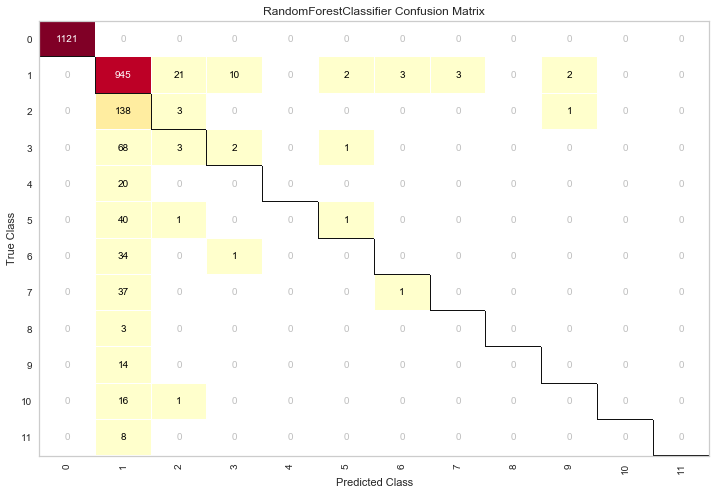

In [25]:
from yellowbrick.style import set_palette
set_palette('flatui')

plt.figure(figsize=(12,8))

# The ConfusionMatrix visualizer taxes a model
cm = ConfusionMatrix(model)

# Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
cm.fit(train_X, train_y)

# To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
# and then creates the confusion_matrix from scikit-learn.
cm.score(test_X, test_y)

# How did we do?

cm.show()

## SGD

In [26]:
# separate y from train_users
y = train_users_df.country_destination
X = train_users_df.drop('country_destination', axis=1)

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV

train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.75, stratify=y)


In [27]:
# ejecutamos carga del dataset y separacion de los conjuntos de entrenamiento y evaluacion

np.random.seed(0)  

#
# 1. Seleccionamos el estimador de clasificacion, en este caso SGDClassifier
#

m = SGDClassifier()

#
# 2. Ejecutamos y entrenamos el clasificador
#

exploring_params = {
        'learning_rate': ['constant'],
        'penalty': ['l2','l1'],
        'eta0': [0.1, 0.01, 0.001],  # Tasa de entrenamiento
        'alpha': [0.1, 0.01, 0.001],  # Tasa de regularización
        'max_iter': [100, 500, 1000]
}

model = GridSearchCV(m, exploring_params)

model.fit( train_X, train_y)

model_print_results( model )

#
# 3. Validamos sobre el conjunto de Test
#

y_true, y_pred = test_y, model.predict(test_X)

classification_print_results(y_true, y_pred)




Mejor conjunto de parámetros:
{'alpha': 0.1, 'eta0': 0.1, 'learning_rate': 'constant', 'max_iter': 500, 'penalty': 'l2'}

Puntajes de la grilla:

Exactitud: 0.730 (+/-0.025) para los parámetros {'alpha': 0.1, 'eta0': 0.1, 'learning_rate': 'constant', 'max_iter': 100, 'penalty': 'l2'}
Exactitud: 0.730 (+/-0.026) para los parámetros {'alpha': 0.1, 'eta0': 0.1, 'learning_rate': 'constant', 'max_iter': 100, 'penalty': 'l1'}
Exactitud: 0.843 (+/-0.000) para los parámetros {'alpha': 0.1, 'eta0': 0.1, 'learning_rate': 'constant', 'max_iter': 500, 'penalty': 'l2'}
Exactitud: 0.712 (+/-0.034) para los parámetros {'alpha': 0.1, 'eta0': 0.1, 'learning_rate': 'constant', 'max_iter': 500, 'penalty': 'l1'}
Exactitud: 0.589 (+/-0.032) para los parámetros {'alpha': 0.1, 'eta0': 0.1, 'learning_rate': 'constant', 'max_iter': 1000, 'penalty': 'l2'}
Exactitud: 0.843 (+/-0.000) para los parámetros {'alpha': 0.1, 'eta0': 0.1, 'learning_rate': 'constant', 'max_iter': 1000, 'penalty': 'l1'}
Exactitud: 0.599 (

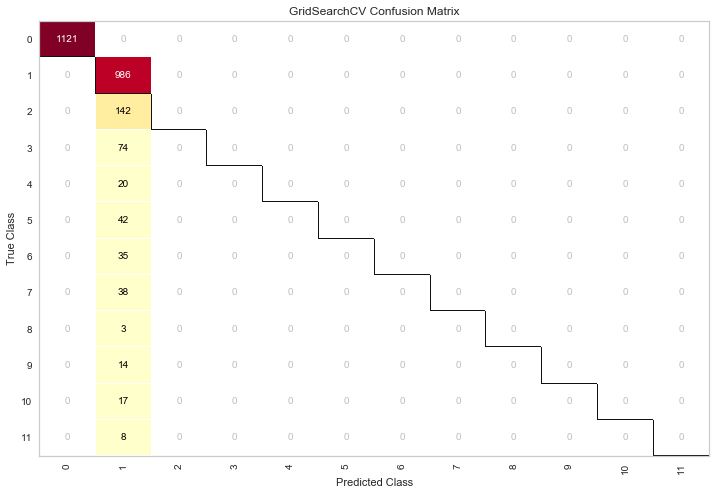

In [28]:
from yellowbrick.style import set_palette
set_palette('flatui')

plt.figure(figsize=(12,8))

# The ConfusionMatrix visualizer taxes a model
cm = ConfusionMatrix(model)

# Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
cm.fit(train_X, train_y)

# To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
# and then creates the confusion_matrix from scikit-learn.
cm.score(test_X, test_y)

# How did we do?

cm.show()

## Probamos prediccion solo sobre has_booked

In [29]:
train_users_df = train_users_df[ train_users_df['has_booked'] == True]
len(train_users_df)

5517

In [30]:
# separate y from train_users
y = train_users_df.country_destination
X = train_users_df.drop('country_destination', axis=1)

train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.75, stratify=y)


In [31]:
model = RandomForestClassifier(n_jobs=2, random_state=0)
model.fit(train_X,train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=2,
                       oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [32]:
y_pred = model.predict(test_X)

In [33]:
print(classification_report(test_y, y_pred))

              precision    recall  f1-score   support

           1       0.72      0.97      0.82       986
           2       0.07      0.01      0.02       142
           3       0.25      0.01      0.03        75
           4       0.00      0.00      0.00        20
           5       0.33      0.05      0.08        42
           6       0.33      0.03      0.05        35
           7       0.00      0.00      0.00        38
           8       0.00      0.00      0.00         3
           9       0.00      0.00      0.00        14
          10       0.00      0.00      0.00        17
          11       0.00      0.00      0.00         8

    accuracy                           0.69      1380
   macro avg       0.16      0.10      0.09      1380
weighted avg       0.55      0.69      0.59      1380



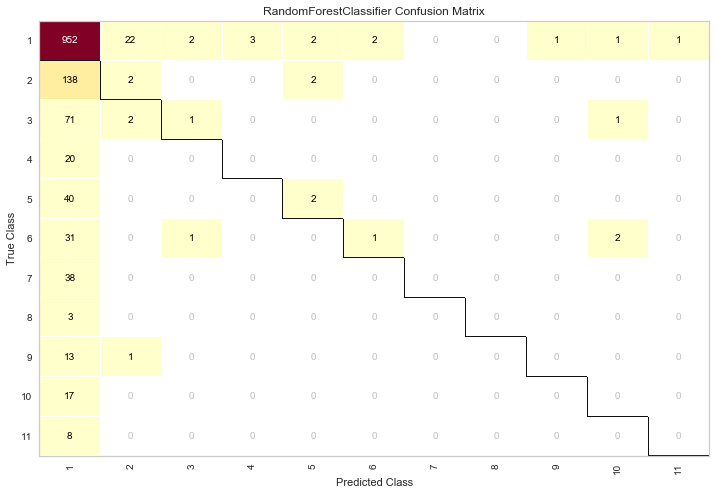

In [34]:
from yellowbrick.style import set_palette
set_palette('flatui')


plt.figure(figsize=(12,8))

# The ConfusionMatrix visualizer taxes a model
cm = ConfusionMatrix(model)

# Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
cm.fit(train_X, train_y)

# To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
# and then creates the confusion_matrix from scikit-learn.
cm.score(test_X, test_y)

# How did we do?

cm.show()

## Probamos utilizando tecnicas de oversampling 

In [64]:
from imblearn.ensemble import BalancedRandomForestClassifier

train_users_df = users_df
y = train_users_df.country_destination
X = train_users_df.drop('country_destination', axis=1)

train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.75, stratify=y)

model = RandomForestClassifier(n_jobs=2, random_state=0)
model = BalancedRandomForestClassifier(max_depth=2, random_state=0)
model.fit(train_X,train_y)

BalancedRandomForestClassifier(bootstrap=True, class_weight=None,
                               criterion='gini', max_depth=2,
                               max_features='auto', max_leaf_nodes=None,
                               min_impurity_decrease=0.0, min_samples_leaf=2,
                               min_samples_split=2,
                               min_weight_fraction_leaf=0.0, n_estimators=100,
                               n_jobs=1, oob_score=False, random_state=0,
                               replacement=False, sampling_strategy='auto',
                               verbose=0, warm_start=False)

In [65]:
y_pred = model.predict(test_X)

In [63]:
print(classification_report(test_y, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13559
           1       0.76      0.06      0.11     11847
           2       0.13      0.25      0.17      1848
           3       0.10      0.06      0.07       907
           4       0.02      0.03      0.03       262
           5       0.04      0.08      0.06       433
           6       0.03      0.30      0.06       416
           7       0.03      0.07      0.05       495
           8       0.00      0.03      0.00        39
           9       0.01      0.05      0.02       147
          10       0.02      0.15      0.03       208
          11       0.01      0.14      0.01       107

    accuracy                           0.50     30268
   macro avg       0.18      0.18      0.13     30268
weighted avg       0.76      0.50      0.51     30268



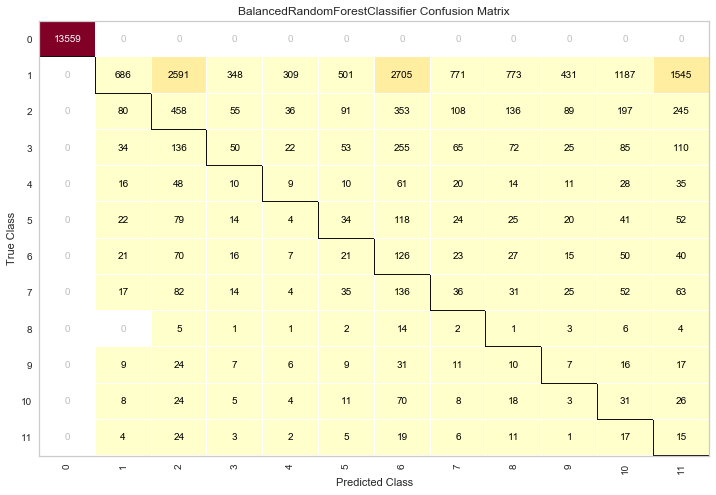

In [61]:
from yellowbrick.style import set_palette
set_palette('flatui')


plt.figure(figsize=(12,8))

# The ConfusionMatrix visualizer taxes a model
cm = ConfusionMatrix(model)

# Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
cm.fit(train_X, train_y)

# To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
# and then creates the confusion_matrix from scikit-learn.
cm.score(test_X, test_y)

# How did we do?

cm.show()

## Probamos utilizando tecnicas de oversampling sobre los usuarios que reservaron

In [70]:
from imblearn.ensemble import BalancedRandomForestClassifier

train_users_df = users_df

train_users_df = train_users_df[ train_users_df['has_booked'] == True]
print(len(train_users_df))

y = train_users_df.country_destination
X = train_users_df.drop('country_destination', axis=1)

train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.75, stratify=y)

model = RandomForestClassifier(n_jobs=2, random_state=0)
model = BalancedRandomForestClassifier(max_depth=2, random_state=0)
model.fit(train_X,train_y)

66836


BalancedRandomForestClassifier(bootstrap=True, class_weight=None,
                               criterion='gini', max_depth=2,
                               max_features='auto', max_leaf_nodes=None,
                               min_impurity_decrease=0.0, min_samples_leaf=2,
                               min_samples_split=2,
                               min_weight_fraction_leaf=0.0, n_estimators=100,
                               n_jobs=1, oob_score=False, random_state=0,
                               replacement=False, sampling_strategy='auto',
                               verbose=0, warm_start=False)

In [71]:
y_pred = model.predict(test_X)

In [72]:
print(classification_report(test_y, y_pred))

              precision    recall  f1-score   support

           1       0.75      0.04      0.08     11847
           2       0.14      0.23      0.17      1848
           3       0.07      0.05      0.06       907
           4       0.01      0.02      0.01       262
           5       0.03      0.00      0.01       433
           6       0.04      0.11      0.05       416
           7       0.04      0.14      0.06       495
           8       0.00      0.03      0.00        39
           9       0.02      0.05      0.03       147
          10       0.02      0.30      0.03       208
          11       0.01      0.33      0.02       107

    accuracy                           0.07     16709
   macro avg       0.10      0.12      0.05     16709
weighted avg       0.56      0.07      0.09     16709



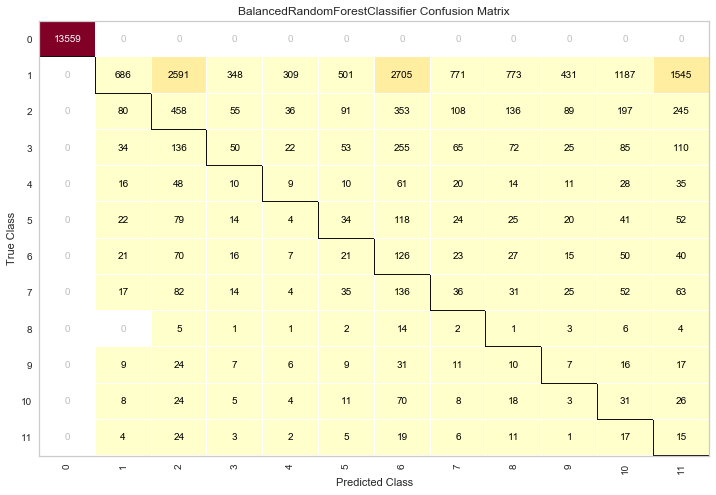

In [61]:
from yellowbrick.style import set_palette
set_palette('flatui')


plt.figure(figsize=(12,8))

# The ConfusionMatrix visualizer taxes a model
cm = ConfusionMatrix(model)

# Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
cm.fit(train_X, train_y)

# To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
# and then creates the confusion_matrix from scikit-learn.
cm.score(test_X, test_y)

# How did we do?

cm.show()